In [1]:
# fill namespace with numpy and matplotlib + static notebook plots
# %pylab inline
%pylab widget
import sk_dsp_comm.sigsys as ss
import sk_dsp_comm.digitalcom as dc
# import sk_dsp_comm.rtlsdr_helper as sdrh
import sk_dsp_comm.pluto_helper as sdrh
import sk_dsp_comm.fir_design_helper as fir_d
import sk_dsp_comm.iir_design_helper as iir_d
import ipywidgets as widgets
import imp # for module reloading
import scipy.signal as signal
from IPython.display import Audio, display
from IPython.display import Image, SVG

Populating the interactive namespace from numpy and matplotlib


In [2]:
#pylab.rcParams['savefig.dpi'] = 100 # default 72
#pylab.rcParams['figure.figsize'] = (6.0, 4.0) # default (6,4)
#%config InlineBackend.figure_formats=['png'] # default for inline viewing
%config InlineBackend.figure_formats=['svg'] # SVG inline viewing
#%config InlineBackend.figure_formats=['pdf'] # render pdf figs for LaTeX
#Image('fname.png',width='80%')

In [3]:
import adi

In [4]:
sdr = adi.Pluto()

# Pluto Stream Class

Now included in the `pluto_helper` is the `Pluto_stream` class. This class contains async methods for reading IQ data from the Pluto sdr, decimating, and playing back audio. Use `pyaudio_helper.available_devices` to see what audio devices are on the machine.

In [3]:
sdrh.pah.available_devices()

{0: {'name': 'MacBook Pro Microphone', 'inputs': 1, 'outputs': 0},
 1: {'name': 'MacBook Pro Speakers', 'inputs': 0, 'outputs': 2}}

Instantiate an object from the `Pluto_stream` Class

In [4]:
sdr_stream = sdrh.Pluto_stream(fc=88.7e6,gain=-10,audio_out=1,pluto_buffer_size=2**15)

# Mono FM Receiver Example

A mono FM receiver implementation is included in the `RTLSDR_stream` class using the `interactive_FM_Rx()` method. This example can be used to make sure everything is running properly and to demostrate some of the functionality of the class.

In [6]:
sdr_stream.interactive_FM_Rx(88.7e6,-10,1,2048,48000)

Sample Rate: 2400000
Center Frequency: 88700000
Gain: 73


Output(outputs=({'output_type': 'stream', 'name': 'stdout', 'text': 'Interactive FM Receiver'},))

interactive(children=(ToggleButtons(description=' ', index=1, options=('Start Streaming', 'Stop Streaming'), s…

interactive(children=(FloatSlider(value=0.0, description='Gain (dB)', layout=Layout(width='90%'), max=6.0, min…

interactive(children=(FloatSlider(value=88.7, continuous_update=False, description='$f_c\\;$', layout=Layout(w…

In [7]:
sdr_stream.show_logs()

Output(outputs=({'output_type': 'stream', 'name': 'stdout', 'text': 'LOGS:\n\x1bChanging Center Frequency …

In [7]:
sdr_stream.clear_logs()

# User-Defined Callbacks

This callback will be called after the initial decimation 

In [5]:
def callback(samples,fs,user_var):
    '''
    User-defined callback function used to process decimated data
    in an RTLSDR_streaming object. 
    
    parameters:
    -----------
    samples: frame of decimated data coming from the stage 1 decimator
    fs: decimated sample rate
    user_var: user-defined variable that is maintained in the class
    
    returns:
    --------
    samples: an ndarray of processed samples if using the audio sink
        or an array of data to be sent to the data sink
    user_var: updated user variable that will be updated in the class
        and returned on the following callback call.
    '''
    # Discriminator
    x = samples
    X=np.real(x)                # X is the real part of the received signal
    Y=np.imag(x)                # Y is the imaginary part of the received signal
    b=np.array([1, -1])         # filter coefficients for discrete derivative
    a=np.array([1, 0])          # filter coefficients for discrete derivative
    derY,yzi=signal.lfilter(b,a,Y,zi=user_var["yzi"])  # derivative of Y, 
    derX,xzi=signal.lfilter(b,a,X,zi=user_var["xzi"])  #    "          X,
    user_var["yzi"] = yzi
    user_var["xzi"] = xzi
    z_bb=(X*derY-Y*derX)/(X**2+Y**2) 
    return z_bb,user_var

In [9]:
sdr_stream.run_user_stream(callback,10,5,user_var={"yzi": zeros(1), "xzi": zeros(1)})

Using default stage 1 decimation filter
Using default stage 2 decimation filter
Using default stage 1 initial conditions
Using default stage 2 initial conditions
Starting SDR and Audio Event Loop



In [10]:
sdr_stream.set_audio_gain_db(-10)

In [11]:
sdr_stream.set_fc(int(99.9e6))

Center Frequency: 99900000


In [12]:
sdr_stream.set_fc(int(103.9e6))

Center Frequency: 103899998


In [13]:
sdr_stream.stop()

Stopping SDR
Stopping Audio
Completed
Completed


## Custom Filters

We can set the filter taps and initial conditions in the `run_user_stream()` method.

In [14]:
M1 = 10
b = signal.firwin(32,2*200e3/float(2.4e6))
stage1_ic = signal.lfilter_zi(b,1)
M2 = 5
bb = signal.firwin(32,2*12e3/float(2.4e6)*M1)
stage2_ic = signal.lfilter_zi(bb,1)

In [15]:
sdr_stream.run_user_stream(callback,M1,M2,b=b,stage1_ic=stage1_ic,bb=bb,stage2_ic=stage2_ic,user_var={"yzi": zeros(1), "xzi": zeros(1)})

Starting SDR and Audio Event Loop



In [16]:
sdr_stream.stop()

Stopping SDR
Stopping Audio
Completed
Completed


## Using the FIR Design Helper

In [17]:
fc = 200e3
trans = 50000
b = fir_d.fir_remez_lpf(fc-trans/2,fc+trans/2,1,40,2.4e6)
M1 = 10
fc2 = 15e3
trans = 5000
M2 = 5
bb = fir_d.fir_remez_lpf(fc2-trans/2,fc2+trans/2,1,40,2.4e6/10)
stage1_ic = signal.lfilter_zi(b,1)
stage2_ic = signal.lfilter_zi(bb,1)

Remez filter taps = 64.
Remez filter taps = 64.


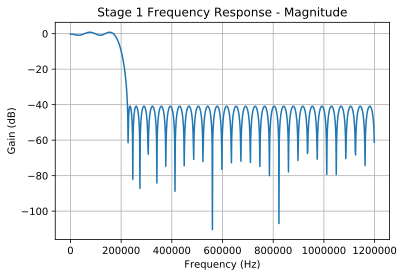

In [18]:
fir_d.freqz_resp_list([b],[1],'dB',fs=2.4e6,Npts=1024)
title('Stage 1 Frequency Response - Magnitude')
grid();

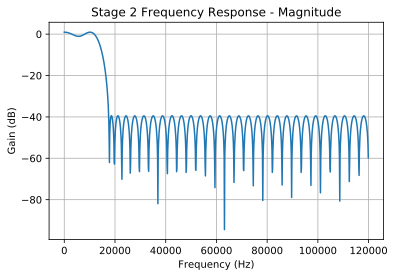

In [19]:
fir_d.freqz_resp_list([bb],[1],'dB',fs=2.4e6/M1,Npts=1024)
title('Stage 2 Frequency Response - Magnitude')
grid();

In [20]:
sdr_stream.run_user_stream(callback,M1,M2,b=b,stage1_ic=stage1_ic,bb=bb,stage2_ic=stage2_ic,user_var={"yzi": zeros(1), "xzi": zeros(1)})

Starting SDR and Audio Event Loop



In [21]:
sdr_stream.set_fc(int(103.9e6))

Center Frequency: 103899998


In [22]:
sdr_stream.stop()

Stopping SDR
Stopping Audio
Completed
Completed


In [23]:
fc = 200e3
taps = 16
b = fir_d.firwin_lpf(taps,fc,2.4e6)
M1 = 10
M2 = 5
fc2 = 14e3
bb = fir_d.firwin_lpf(taps,fc2,2.4e6/M1)
stage1_ic = signal.lfilter_zi(b,1)
stage2_ic = signal.lfilter_zi(bb,1)

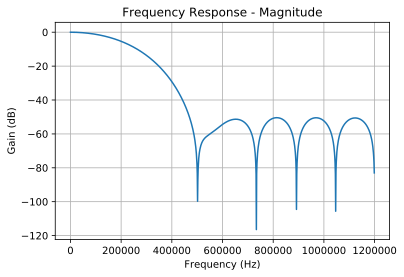

In [24]:
fir_d.freqz_resp_list([b],[1],'dB',fs=2.4e6,Npts=1024)
grid();

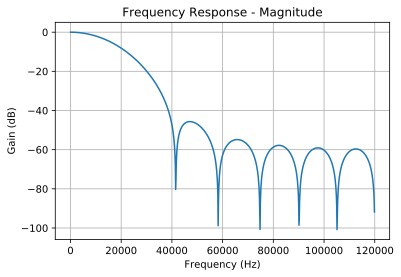

In [25]:
fir_d.freqz_resp_list([bb],[1],'dB',fs=2.4e6/M1,Npts=1024)
grid();

In [26]:
sdr_stream.run_user_stream(callback,10,5,b=b,stage1_ic=stage1_ic,bb=bb,stage2_ic=stage2_ic,user_var={"yzi": zeros(1), "xzi": zeros(1)})

Starting SDR and Audio Event Loop



In [27]:
sdr_stream.stop()

Stopping SDR
Stopping Audio
Completed
Completed


## Using IIR Design Helper

In [28]:
import sk_dsp_comm.iir_design_helper as iir_d

In [29]:
fc = 200e3
trans = 50000
b,a,sos = iir_d.IIR_lpf(fc,fc+trans,1,10,2.4e6,'butter')
M1 = 10
M2 = 5
fc2 = 15e3
trans = 5000
bb,aa,sos2 = iir_d.IIR_lpf(fc2,fc2+trans,1,10,2.4e6/M1,'butter')
stage1_ic = signal.lfilter_zi(b,a)
stage2_ic = signal.lfilter_zi(bb,aa)

IIR butter order = 8.
IIR butter order = 6.


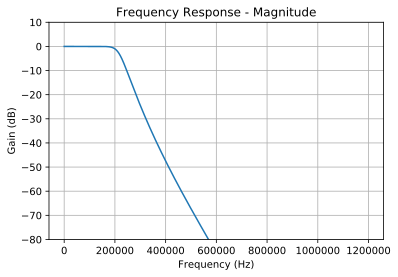

In [30]:
iir_d.freqz_resp_list([b],[a],fs=2.4e6,Npts=1024)
ylim(-80,10)
grid()

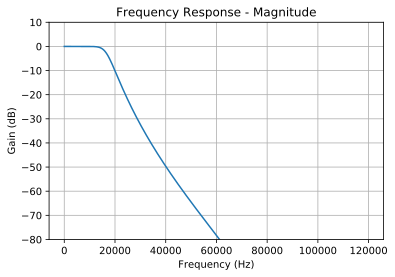

In [31]:
iir_d.freqz_resp_list([bb],[aa],fs=2.4e6/M1,Npts=1024)
ylim(-80,10)
grid()

In [32]:
sdr_stream.run_user_stream(callback,10,5,b,stage1_ic,a,bb,stage2_ic,aa,user_var={"yzi": zeros(1), "xzi": zeros(1)})

Starting SDR and Audio Event Loop



In [33]:
sdr_stream.stop()

Stopping SDR
Stopping Audio
Completed
Completed


In [34]:
fc = 200e3
trans = 5000
b,a,sos = iir_d.IIR_lpf(fc,fc+trans,1,10,2.4e6,'cheby1')
M1 = 10
M2 = 5
fc2 = 17e3
trans = 500
bb,aa,sos2 = iir_d.IIR_lpf(fc2,fc2+trans,1,10,2.4e6/M1,'cheby1')
stage1_ic = signal.lfilter_zi(b,a)
stage2_ic = signal.lfilter_zi(bb,aa)

IIR cheby1 order = 11.
IIR cheby1 order = 10.


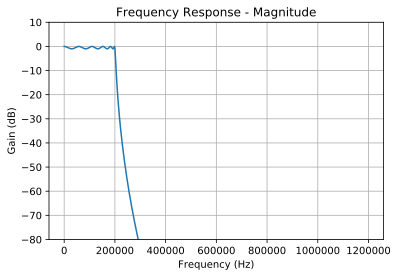

In [35]:
iir_d.freqz_resp_list([b],[a],fs=2.4e6,Npts=1024)
ylim(-80,10)
grid()

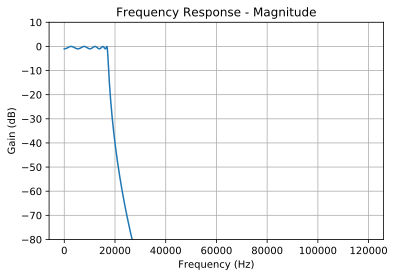

In [36]:
iir_d.freqz_resp_list([bb],[aa],fs=2.4e6/M1,Npts=1024)
ylim(-80,10)
grid()

In [37]:
sdr_stream.run_user_stream(callback,10,5,b,stage1_ic,a,bb,stage2_ic,aa,user_var={"yzi": zeros(1), "xzi": zeros(1)})

Starting SDR and Audio Event Loop



In [38]:
sdr_stream.stop()

Stopping SDR
Stopping Audio
Completed
Completed


# Plotting

In [39]:
sdr_stream.run_user_stream(callback,10,5,user_var={"yzi": zeros(1), "xzi": zeros(1)})

Using default stage 1 decimation filter
Using default stage 2 decimation filter
Using default stage 1 initial conditions
Using default stage 2 initial conditions
Starting SDR and Audio Event Loop



In [40]:
sdr_stream.set_fc(int(99.9e6))

Center Frequency: 99900000


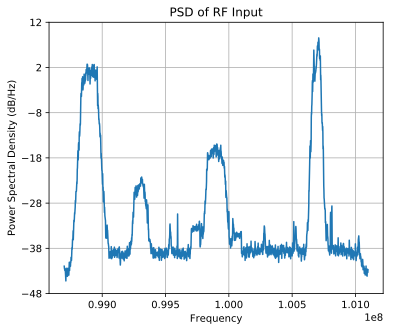

In [41]:
await sdr_stream.plot_rf(2048)

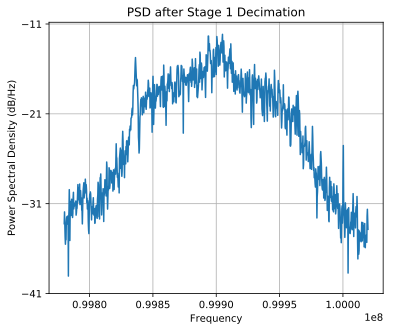

In [42]:
await sdr_stream.plot_stage1()

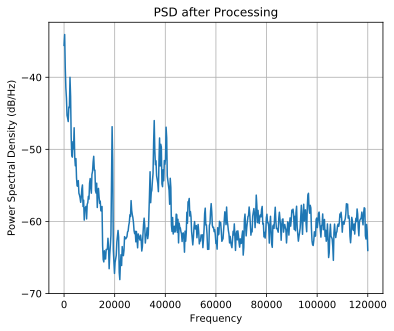

In [43]:
await sdr_stream.plot_processed_stage1()

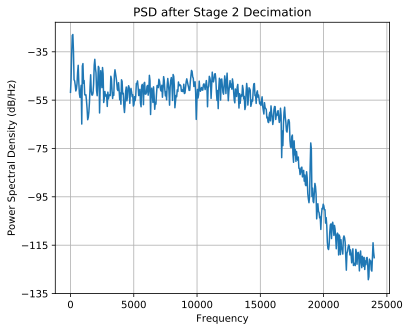

In [44]:
await sdr_stream.plot_stage2()

In [45]:
sdr_stream.stop()

Stopping SDR
Stopping Audio
Completed
Completed


## Pulling frames from stream

In [46]:
sdr_stream.run_user_stream(callback,10,5,user_var={"yzi": zeros(1), "xzi": zeros(1)})

Using default stage 1 decimation filter
Using default stage 2 decimation filter
Using default stage 1 initial conditions
Using default stage 2 initial conditions
Starting SDR and Audio Event Loop



In [47]:
rf_frame = await sdr_stream.get_rf_frame()

131080


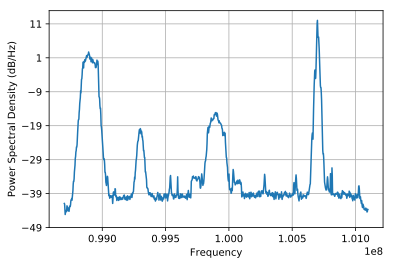

In [48]:
Nfft = 2**10
print(len(rf_frame))
Px,f = psd(rf_frame,Nfft,sdr_stream.get_sample_rate(),sdr_stream.get_center_freq());

In [49]:
stage1_frame = await sdr_stream.get_stage1_frame()

13107


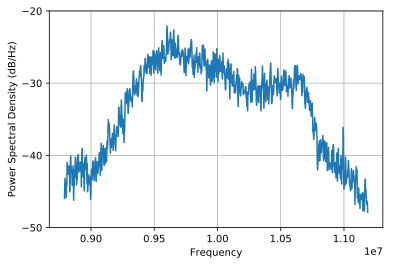

In [50]:
print(len(stage1_frame))
psd(stage1_frame,Nfft,2.4e6,99.9e6/10);

In [51]:
processed_stage1_frame = await sdr_stream.get_processed_stage1_frame()

13107


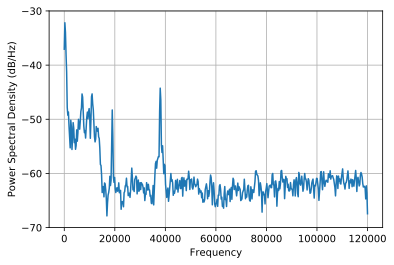

In [52]:
Nfft = 2**10
print(len(processed_stage1_frame))
psd(processed_stage1_frame,Nfft,2.4e6/10,0);

In [53]:
stage2_frame = await sdr_stream.get_stage2_frame()

2621


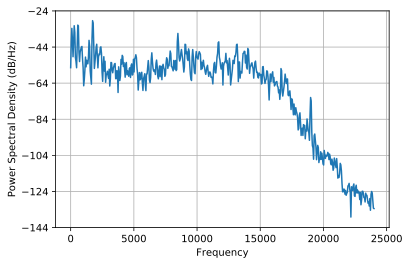

In [54]:
Nfft = 2**10
print(len(stage2_frame))
psd(stage2_frame,Nfft,2.4e6/50,0);

In [55]:
sdr_stream.stop()

Stopping SDR
Stopping Audio
Completed
Completed


# Spectrum Analyzer

In [6]:
%pylab widget

Populating the interactive namespace from numpy and matplotlib


In [17]:
pylab.rcParams['figure.figsize'] = (12.0, 12.0)

In [7]:
sdr_stream.run_user_stream(callback,10,5,user_var={"yzi": zeros(1), "xzi": zeros(1)})

Using default stage 1 decimation filter
Using default stage 2 decimation filter
Using default stage 1 initial conditions
Using default stage 2 initial conditions
Starting SDR and Audio Event Loop



In [18]:
sdr_stream.run_plot_rf_stream(1024,2,invert=True, w=15,h=6)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…

In [9]:
sdr_stream.set_fc(int(103.9e6))

Center Frequency: 103899998


In [19]:
sdr_stream.set_NFFT(256)

In [20]:
sdr_stream.set_refresh_rate(4)

In [21]:
sdr_stream.toggle_invert()

In [22]:
sdr_stream.stop_rf_plot()

In [23]:
sdr_stream.run_plot_stage1_stream(1024,1,w=12,h=6)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…

In [24]:
sdr_stream.stop_stage1_plot()

In [25]:
sdr_stream.run_plot_processed_stage1_stream(1024,1,w=12,h=6)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…

In [26]:
sdr_stream.stop_processed_stage1_plot()

In [27]:
sdr_stream.run_plot_stage2_stream(1024,1,w=12,h=6)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…

In [28]:
sdr_stream.stop_all()

# Using Widgets

In [29]:
import ipywidgets as widgets

## Frequency Slider

In [30]:
freq_slider = widgets.FloatSlider(
    value=103.9,
    min=87.5,
    max=108,
    step=0.2,
    description=r'$f_c\;\mathrm{(MHz)}$',
    continuous_update=True,
    orientation='horizontal',
    readout_format='0.1f',
    layout=widgets.Layout(
        width='90%',
    ) 
)
freq_slider.style.handle_color = 'lightblue'



In [31]:
def set_freq_MHz(fc):
    sdr_stream.set_fc(fc*1e6)

In [32]:
sdr_stream.run_user_stream(callback,10,5,user_var={"yzi": zeros(1), "xzi": zeros(1)})

In [33]:
center_freq_widget = widgets.interactive(set_freq_MHz, fc=freq_slider)
display(center_freq_widget)

interactive(children=(FloatSlider(value=103.9, description='$f_c\\;\\mathrm{(MHz)}$', layout=Layout(width='90%…

In [34]:
sdr_stream.run_plot_rf_stream(w=12,h=6)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…

In [35]:
sdr_stream.stop_all()

Stopping SDR
Stopping Audio
Completed
Stopped RF PSD Stream
Completed


## Audio Gain Slider

In [36]:
audio_gain_slider = widgets.FloatSlider(
    value=-3,
    min=-60,
    max=6,
    step=0.1,
    description=r'Gain (dB)',
    continuous_update=True,
    orientation='horizontal',
    readout_format='0.1f',
    layout=widgets.Layout(
        width='90%',
    ) 
)
audio_gain_slider.style.handle_color = 'lightgreen'


In [37]:
def set_audio_gain_db(db_gain):
    gain = 10**(db_gain/20)
    sdr_stream.set_audio_gain(gain)

In [38]:
audio_gain_widget = widgets.interactive(set_audio_gain_db, db_gain=audio_gain_slider)

In [39]:
display(audio_gain_widget)
display(center_freq_widget)

interactive(children=(FloatSlider(value=-3.0, description='Gain (dB)', layout=Layout(width='90%'), max=6.0, mi…

interactive(children=(FloatSlider(value=103.9, description='$f_c\\;\\mathrm{(MHz)}$', layout=Layout(width='90%…

In [40]:
sdr_stream.run_user_stream(callback,10,5,user_var={"yzi": zeros(1), "xzi": zeros(1)})

In [41]:
sdr_stream.stop()

Stopping SDR
Stopping Audio
Completed
Completed


## On/Off Toggle Buttons

In [42]:
def radio_on_off(selection):
    if(selection == 'On'):
        def my_callback(samples,fs,user_val):
            # Discriminator
            x = samples
            X=np.real(x)                # X is the real part of the received signal
            Y=np.imag(x)                # Y is the imaginary part of the received signal
            b=np.array([1, -1])         # filter coefficients for discrete derivative
            a=np.array([1, 0])          # filter coefficients for discrete derivative
            derY=signal.lfilter(b,a,Y)  # derivative of Y, 
            derX=signal.lfilter(b,a,X)  #    "          X,
            z_bb=(X*derY-Y*derX)/(X**2+Y**2)
            return z_bb,user_val
        if(not sdr_stream.keep_streaming):
            sdr_stream.run_user_stream(my_callback,10,5,user_var={"yzi": zeros(1), "xzi": zeros(1)})
    else:
        sdr_stream.stop()

In [43]:
on_off = widgets.ToggleButtons(
    options=['On', 'Off'],
    description = ' ',
    value = 'Off'
)
on_off.style.button_width = "400px"
on_off.style.description_width = "1px"

In [44]:
on_off_widget = widgets.interactive(radio_on_off,selection=on_off)

In [45]:
display(on_off_widget)
display(audio_gain_widget)
display(center_freq_widget)

interactive(children=(ToggleButtons(description=' ', index=1, options=('On', 'Off'), style=ToggleButtonsStyle(…

interactive(children=(FloatSlider(value=0.8, description='Gain (dB)', layout=Layout(width='90%'), max=6.0, min…

interactive(children=(FloatSlider(value=103.9, description='$f_c\\;\\mathrm{(MHz)}$', layout=Layout(width='90%…

## Adjustable Stage 1 Filter

In [46]:
stage1_fc = widgets.FloatSlider(
    value=100,
    min=2,
    max=200,
    step=0.1,
    description=r'$f_{cS1} \;\mathrm{(KHz)}$',
    continuous_update=False,
    orientation='horizontal',
    readout_format='0.1f',
    layout=widgets.Layout(
        width='90%',
    ) 
)
stage1_fc.style.handle_color = 'orange'

In [47]:
def stage1_fc_change(fc):
    b = fir_d.firwin_lpf(64,2*fc*1e3,2.4e6)
    stage1_ic = signal.lfilter_zi(b,1)
    sdr_stream.set_stage1_coeffs(b,zi=stage1_ic)

In [48]:
stage1_fc_widget = widgets.interactive(stage1_fc_change,fc=stage1_fc)

In [49]:
display(on_off_widget)
display(audio_gain_widget)
display(stage1_fc_widget)
display(center_freq_widget)

interactive(children=(ToggleButtons(description=' ', index=1, options=('On', 'Off'), style=ToggleButtonsStyle(…

interactive(children=(FloatSlider(value=0.8, description='Gain (dB)', layout=Layout(width='90%'), max=6.0, min…

interactive(children=(FloatSlider(value=100.0, continuous_update=False, description='$f_{cS1} \\;\\mathrm{(KHz…

interactive(children=(FloatSlider(value=103.9, description='$f_c\\;\\mathrm{(MHz)}$', layout=Layout(width='90%…

In [50]:
sdr_stream.run_plot_stage1_stream(1024,2,w=15,h=6)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…

In [51]:
sdr_stream.stop_stage1_plot()

## Adjustable Stage 2 Filter

In [52]:
stage2_fc = widgets.FloatSlider(
    value=12,
    min=2,
    max=20,
    step=0.1,
    description=r'$f_{cS2} \;\mathrm{(KHz)}$',
    continuous_update=False,
    orientation='horizontal',
    readout_format='0.1f',
    layout=widgets.Layout(
        width='90%',
    ) 
)
stage2_fc.style.handle_color = 'purple'

In [53]:
def stage2_fc_change(fc):
    bb = fir_d.firwin_lpf(64,fc*1e3,2.4e6/10)
    stage2_ic = signal.lfilter_zi(bb,1)
    sdr_stream.set_stage2_coeffs(bb,zi=stage2_ic)

In [54]:
stage2_fc_widget = widgets.interactive(stage2_fc_change,fc=stage2_fc)

In [55]:
display(on_off_widget)
display(audio_gain_widget)
display(stage1_fc_widget)
display(stage2_fc_widget)
display(center_freq_widget)

interactive(children=(ToggleButtons(description=' ', options=('On', 'Off'), style=ToggleButtonsStyle(button_wi…

interactive(children=(FloatSlider(value=0.8, description='Gain (dB)', layout=Layout(width='90%'), max=6.0, min…

interactive(children=(FloatSlider(value=144.3, continuous_update=False, description='$f_{cS1} \\;\\mathrm{(KHz…

interactive(children=(FloatSlider(value=12.0, continuous_update=False, description='$f_{cS2} \\;\\mathrm{(KHz)…

interactive(children=(FloatSlider(value=103.9, description='$f_c\\;\\mathrm{(MHz)}$', layout=Layout(width='90%…

In [56]:
sdr_stream.run_plot_stage2_stream(1024,2,w=15,h=6)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…

In [57]:
sdr_stream.stop_stage2_plot()

In [59]:
sdr_stream.stop()

Stopping SDR
Stopping Audio
Completed
Completed


# Data Sink

In [60]:
import asyncio

In [61]:
sdr_stream.set_pluto_buffer_size(16)

In [62]:
def no_audio_callback(samples,fs,user_var):
    frame_count = user_var
    user_var = user_var+1
    return array([frame_count]),user_var

In [63]:
global keep_collecting

In [64]:
async def handle_data_out():
    global keep_collecting
    keep_collecting = True
    while keep_collecting:
        data_out = await sdr_stream.get_data_out_async()
        print(data_out)
    sdr_stream.reset_data_out_queue()
    print('Done')

In [65]:
sdr_stream.run_user_stream(no_audio_callback,1,1,audio_sink=False,user_var=1)
task = asyncio.create_task(handle_data_out())

Using default stage 1 decimation filter
Using default stage 1 initial conditions
Starting SDR and Audio Event Loop

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
[17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32.]
[33. 34. 35. 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48.]
[49. 50. 51. 52. 53. 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64.]


In [66]:
keep_collecting = False

[65. 66. 67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80.]
Done


In [67]:
sdr_stream.stop()

Stopping SDR
Completed
